# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

You can use ** Keras ** to implement your model. Read more at [keras.io](https://keras.io/).

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0)). You are not expected to model your architecture precisely using this model nor get the same performance levels, but this is more to show an exampe of an approach used to solve this particular problem. We encourage you to try out different architectures for yourself and see what works best for you. Here is a useful [forum post](https://discussions.udacity.com/t/goodfellow-et-al-2013-architecture/202363) discussing the architecture as described in the paper and here is [another one](https://discussions.udacity.com/t/what-loss-function-to-use-for-multi-digit-svhn-training/176897) discussing the loss function.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Importing all the right libraries

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from skimage.transform import resize
import tensorflow as tf
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

### Downloading MNIST images and extracting them to pickles file

In [2]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./notMNIST_large.tar.gz
Found and verified ./notMNIST_small.tar.gz


In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

./notMNIST_large already present - Skipping extraction of ./notMNIST_large.tar.gz.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
./notMNIST_small already present - Skipping extraction of ./notMNIST_small.tar.gz.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


In [4]:
from IPython.display import display_png,Image
image_files = os.listdir(os.curdir + "/notMNIST_small/A")
j = 0
for image_file in image_files:
    image_file = os.curdir + "/notMNIST_small/A/" + image_file
    img = plt.imread(image_file)
    print (img.shape)
    i = Image(image_file)
    display(i)
    j += 1
    if j > 5:
        break

(28, 28)


(28, 28)


(28, 28)


(28, 28)


(28, 28)


(28, 28)


In [5]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

./notMNIST_large/A.pickle already present - Skipping pickling.
./notMNIST_large/B.pickle already present - Skipping pickling.
./notMNIST_large/C.pickle already present - Skipping pickling.
./notMNIST_large/D.pickle already present - Skipping pickling.
./notMNIST_large/E.pickle already present - Skipping pickling.
./notMNIST_large/F.pickle already present - Skipping pickling.
./notMNIST_large/G.pickle already present - Skipping pickling.
./notMNIST_large/H.pickle already present - Skipping pickling.
./notMNIST_large/I.pickle already present - Skipping pickling.
./notMNIST_large/J.pickle already present - Skipping pickling.
./notMNIST_small/A.pickle already present - Skipping pickling.
./notMNIST_small/B.pickle already present - Skipping pickling.
./notMNIST_small/C.pickle already present - Skipping pickling.
./notMNIST_small/D.pickle already present - Skipping pickling.
./notMNIST_small/E.pickle already present - Skipping pickling.
./notMNIST_small/F.pickle already present - Skipping pi

In [6]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


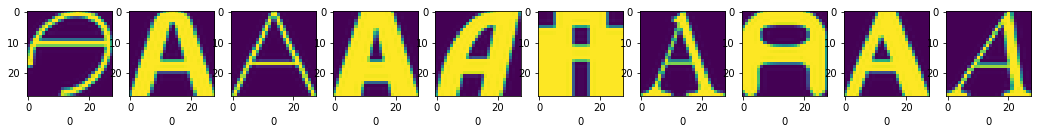

In [7]:
%matplotlib inline
fig = plt.figure(figsize=(18,5))
for i in range(1,11):
    fig.add_subplot(1, 10, i) 
    plt.imshow(train_dataset[i])
    plt.xlabel(train_labels[i])

In [8]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

In [9]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [10]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800503


### Creating training data set with multiple characters

Downloaded training images have just one letter. In the code below, combining multiple images together to form images that consist of multiple characters. Each image may consist of 1 to 5 letters. Upon combining multiple images, also resized the images to 32x32.

In [11]:
import numpy as np
num_of_train_records = 70000
max_num_of_char = 5

train_temp_dataset = []
train_temp_labels = []
#index_set = []

for i in range(num_of_train_records):
    label = []
    #Randomly selecting number of characters
    num_of_char = np.random.randint(1,6)
    label.append(num_of_char)
    for i in range(num_of_char):
        if i == 0:
            index = np.random.randint(len(train_dataset))
            #tmp_index.append(index)
            image = train_dataset[index]
            label.append(train_labels[index])
        else:
            index = np.random.randint(len(train_dataset))
            #tmp_index.append(index)
            image = np.concatenate((image,train_dataset[index]), axis=1)
            label.append(train_labels[index])
    for i in range(num_of_char, max_num_of_char):
        label.append(10)
    #index_set.append(tmp_index)
    train_temp_dataset.append(resize(image,(32,32),mode='symmetric'))
    train_temp_labels.append(label)

#print (label_temp_dataset)
#print (index_set)
            
    

#### Displaying combined images

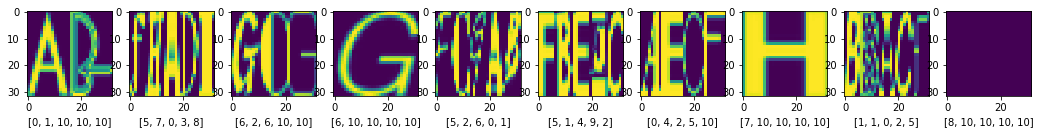

In [12]:
%matplotlib inline
fig = plt.figure(figsize=(18,5))
for i in range(1,11):
    fig.add_subplot(1, 10, i) 
    plt.imshow(train_temp_dataset[i])
    plt.xlabel(train_temp_labels[i][1:6])

### Creating test data set with multiple characters

Downloaded testing images have just one letter. In the code below, combining multiple images together to form images that consist of multiple characters. Each image may consist of 1 to 5 letters. Upon combining multiple images, also resized the images to 32x32.

In [13]:
import numpy as np
num_of_test_records = 10000
max_num_of_char = 5

test_temp_dataset = []
test_temp_labels = []
#index_set = []

for i in range(num_of_test_records):
    label = []
    #tmp_index = []
    #Randomly selecting number of characters
    num_of_char = np.random.randint(1,6)
    label.append(num_of_char)
    for i in range(num_of_char):
        if i == 0:
            index = np.random.randint(len(test_dataset))
            #tmp_index.append(index)
            image = test_dataset[index]
            label.append(test_labels[index])
        else:
            index = np.random.randint(len(test_dataset))
            #tmp_index.append(index)
            image = np.concatenate((image,test_dataset[index]), axis=1)
            label.append(test_labels[index])
    for i in range(num_of_char, max_num_of_char):
        label.append(10)
    #index_set.append(tmp_index)
    test_temp_dataset.append(resize(image,(32,32),mode='symmetric'))
    test_temp_labels.append(label)

#print (test_temp_labels)

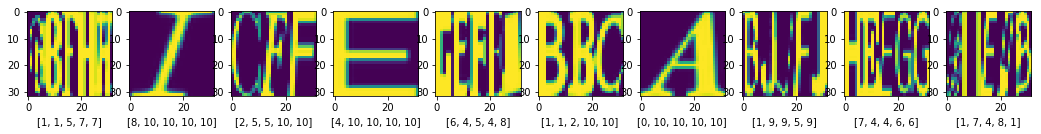

In [14]:
%matplotlib inline
fig = plt.figure(figsize=(18,5))
for i in range(1,11):
    fig.add_subplot(1, 10, i) 
    plt.imshow(test_temp_dataset[i])
    plt.xlabel(test_temp_labels[i][1:6])

### Creating validation data set with multiple characters

Downloaded validation images have just one letter. In the code below, combining multiple images together to form images that consist of multiple characters. Each image may consist of 1 to 5 letters. Upon combining multiple images, also resized the images to 32x32.

In [15]:
import numpy as np
num_of_validation_records = 10000
max_num_of_char = 5

valid_temp_dataset = []
valid_temp_labels = []
#index_set = []

for i in range(num_of_validation_records):
    label = []
    #tmp_index = []
    #Randomly selecting number of characters
    num_of_char = np.random.randint(1,6)
    label.append(num_of_char)
    for i in range(num_of_char):
        if i == 0:
            index = np.random.randint(len(valid_dataset))
            #tmp_index.append(index)
            image = valid_dataset[index]
            label.append(valid_labels[index])
        else:
            index = np.random.randint(len(test_dataset))
            #tmp_index.append(index)
            image = np.concatenate((image,valid_dataset[index]), axis=1)
            label.append(valid_labels[index])
    for i in range(num_of_char, max_num_of_char):
        label.append(10)
    #index_set.append(tmp_index)
    valid_temp_dataset.append(resize(image,(32,32),mode='symmetric'))
    valid_temp_labels.append(label)


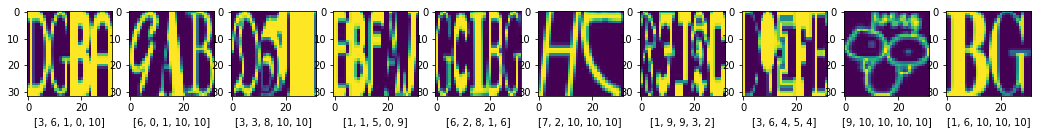

In [16]:
%matplotlib inline
fig = plt.figure(figsize=(18,5))
for i in range(1,11):
    fig.add_subplot(1, 10, i) 
    plt.imshow(valid_temp_dataset[i])
    plt.xlabel(valid_temp_labels[i][1:6])

### Transformation of data into gray scale arrays

In [17]:
train_f_dataset = np.array(train_temp_dataset)
train_f_labels = np.array(train_temp_labels)
test_f_dataset = np.array(test_temp_dataset)
test_f_labels = np.array(test_temp_labels)
valid_f_dataset = np.array(valid_temp_dataset)
valid_f_labels = np.array(valid_temp_labels)


In [18]:
train_f_dataset = train_f_dataset.reshape(train_f_dataset.shape[0],32,32,1).astype(np.float32)
test_f_dataset = test_f_dataset.reshape(test_f_dataset.shape[0],32,32,1).astype(np.float32)
valid_f_dataset = valid_f_dataset.reshape(valid_f_dataset.shape[0],32,32,1).astype(np.float32)
train_f_labels = train_f_labels.astype(np.float32)
test_f_labels = test_f_labels.astype(np.float32)
valid_f_labels = valid_f_labels.astype(np.float32)
print ("Training data shape is: ", train_f_dataset.shape)
print ("Training label shape is: ", train_f_labels.shape)
print ("Test data shape is: ", test_f_dataset.shape)
print ("Test label shape is: ", test_f_labels.shape)
print ("Validation data shape is: ", valid_f_dataset.shape)
print ("Validation label shape is: ", valid_f_labels.shape)


Training data shape is:  (70000, 32, 32, 1)
Training label shape is:  (70000, 6)
Test data shape is:  (10000, 32, 32, 1)
Test label shape is:  (10000, 6)
Validation data shape is:  (10000, 32, 32, 1)
Validation label shape is:  (10000, 6)


### Visualization to view number of charcters in training, testing and validation data set images

In [19]:
from collections import Counter

train_num_length = Counter(train_f_labels[:,0])
test_num_length = Counter(test_f_labels[:,0])
valid_num_length = Counter(valid_f_labels[:,0])

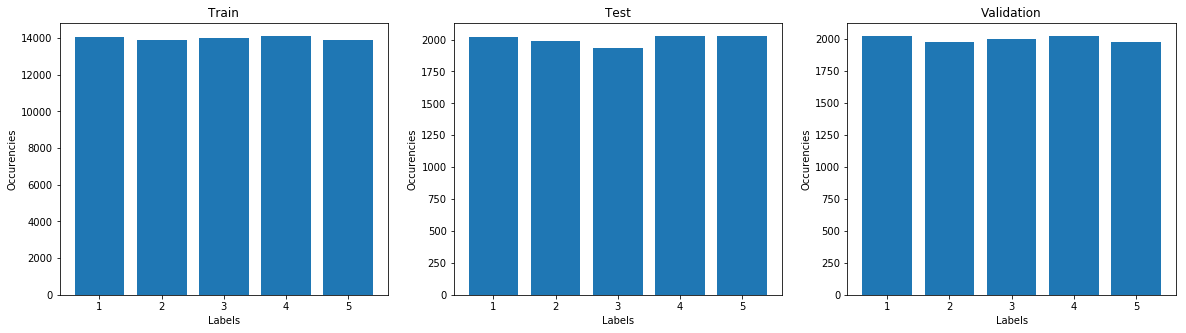

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

ax1.bar(list(train_num_length.keys()), list(train_num_length.values()), align='center')
ax1.set_xticks(list(train_num_length.keys()))
ax1.set_title('Train')
ax1.set_xlabel('Labels')
ax1.set_ylabel('Occurencies')

ax2.bar(list(test_num_length.keys()), list(test_num_length.values()), align='center')
ax2.set_xticks(list(test_num_length.keys()))
ax2.set_title('Test')
ax2.set_xlabel('Labels')
ax2.set_ylabel('Occurencies')

ax3.bar(list(valid_num_length.keys()), list(valid_num_length.values()), align='center')
ax3.set_xticks(list(valid_num_length.keys()))
ax3.set_title('Validation')
ax3.set_xlabel('Labels')
ax3.set_ylabel('Occurencies')

plt.show()

### Visualization to view how each letter is distributed among training, testing and validation data set

In [21]:
from collections import Counter

# Remove classes of empty labels
train_digits = Counter(train_f_labels[:,1:6].flatten()[np.where(train_f_labels[:,1:6].flatten() != 10)])
test_digits = Counter(test_f_labels[:,1:6].flatten()[np.where(test_f_labels[:,1:6].flatten() != 10)])
valid_digits = Counter(valid_f_labels[:,1:6].flatten()[np.where(valid_f_labels[:,1:6].flatten() != 10)])

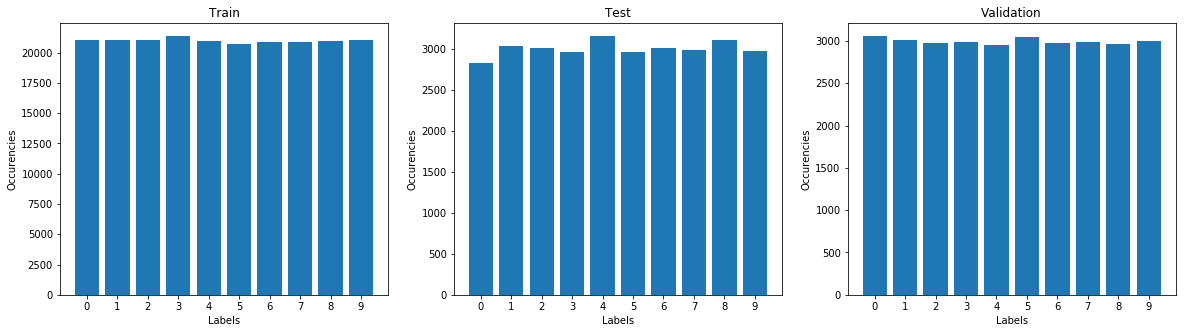

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

ax1.bar(list(train_digits.keys()), list(train_digits.values()), align='center')
ax1.set_xticks(list(train_digits.keys()))
ax1.set_title('Train')
ax1.set_xlabel('Labels')
ax1.set_ylabel('Occurencies')

ax2.bar(list(test_digits.keys()), list(test_digits.values()), align='center')
ax2.set_xticks(list(test_digits.keys()))
ax2.set_title('Test')
ax2.set_xlabel('Labels')
ax2.set_ylabel('Occurencies')

ax3.bar(list(valid_digits.keys()), list(valid_digits.values()), align='center')
ax3.set_xticks(list(valid_digits.keys()))
ax3.set_title('Validation')
ax3.set_xlabel('Labels')
ax3.set_ylabel('Occurencies')

plt.show()

### Constructing 10 layers CNN using Tensorflow

    Input: batch_size x 32 x 32 x 1
    C1: convolutional layer, batch_size x 28 x 28 x 32, filter size: 5 x 5 x 1 x 32
    P2: pooling layer, batch_size x 14 x 14 x 32
    C3: convolutional layer, batch_size x 10 x 10 x 64, filter size: 5 x 5 x 32 x 64
    P4: pooling layer, batch_size x 5 x 5 x 64
    C5: convolutional layer, batch_size x 1 x 1 x 512, filter size: 5 x 5 x 64 x 512
    Dropout
    F6: fully-connected layer 1, weight size: batch_size x 512
    F7: fully-connected layer 2, weight size: batch_size x 128
    F8: fully-connected layer 3, weight size: batch_size x 32
    Output layer, weight size: batch_size x 11

In [23]:
def gaussian_filter(kernel_shape):
    x = np.zeros(kernel_shape, dtype = float)
    mid = np.floor(kernel_shape[0] / 2.)
    
    for kernel_idx in range(0, kernel_shape[2]):
        for i in range(0, kernel_shape[0]):
            for j in range(0, kernel_shape[1]):
                x[i, j, kernel_idx, 0] = gauss(i - mid, j - mid)
    
    return tf.convert_to_tensor(x / np.sum(x), dtype=tf.float32)

In [24]:
def gauss(x, y, sigma=3.0):
    Z = 2 * np.pi * sigma ** 2
    return  1. / Z * np.exp(-(x ** 2 + y ** 2) / (2. * sigma ** 2))

In [25]:
def LecunLCN(X, image_shape, threshold=1e-4, radius=7, use_divisor=True):
    """Local Contrast Normalization"""
    """[http://yann.lecun.com/exdb/publis/pdf/jarrett-iccv-09.pdf]"""

    # Get Gaussian filter
    filter_shape = (radius, radius, image_shape[3], 1)

    #self.filters = theano.shared(self.gaussian_filter(filter_shape), borrow=True)
    filters = gaussian_filter(filter_shape)
    X = tf.convert_to_tensor(X, dtype=tf.float32)
    # Compute the Guassian weighted average by means of convolution
    convout = tf.nn.conv2d(X, filters, [1,1,1,1], 'SAME')

    # Subtractive step
    mid = int(np.floor(filter_shape[1] / 2.))

    # Make filter dimension broadcastable and subtract
    centered_X = tf.subtract(X, convout)

    # Boolean marks whether or not to perform divisive step
    if use_divisor:
        # Note that the local variances can be computed by using the centered_X
        # tensor. If we convolve this with the mean filter, that should give us
        # the variance at each point. We simply take the square root to get our
        # denominator

        # Compute variances
        sum_sqr_XX = tf.nn.conv2d(tf.square(centered_X), filters, [1,1,1,1], 'SAME')

        # Take square root to get local standard deviation
        denom = tf.sqrt(sum_sqr_XX)

        per_img_mean = tf.reduce_mean(denom)
        divisor = tf.maximum(per_img_mean, denom)
        # Divisise step
        new_X = tf.truediv(centered_X, tf.maximum(divisor, threshold))
    else:
        new_X = centered_X
    return new_X

In [26]:
def accuracy(predictions, labels, printstat=False):
    return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] / predictions.shape[0])

In [28]:
image_size = 32
num_labels = 11 # 0-9, + blank 
num_channels = 1 # grayscale

batch_size = 64
patch_size = 5
depth1 = 32
depth2 = 64
depth3 = 128
num_hidden1 = 512
num_hidden2 = 128
num_hidden3 = 32
shape = [batch_size, image_size, image_size, num_channels]

#Input: batch_size x 32 x 32 x 1
#C1: convolutional layer, batch_size x 28 x 28 x 32, filter size: 5 x 5 x 1 x 32
#P2: pooling layer, batch_size x 14 x 14 x 32
#C3: convolutional layer, batch_size x 10 x 10 x 64, filter size: 5 x 5 x 32 x 64
#P4: pooling layer, batch_size x 5 x 5 x 64
#C5: convolutional layer, batch_size x 1 x 1 x 512, filter size: 5 x 5 x 64 x 512
#Dropout
#F6: fully-connected layer 1, weight size: batch_size x 512
#F7: fully-connected layer 2, weight size: batch_size x 128
#F8: fully-connected layer 3, weight size: batch_size x 32
#Output layer, weight size: batch_size x 11

train_size = train_f_labels.shape[0]

graph = tf.Graph()
with graph.as_default():

    # Input data placeholders.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
    tf_valid_dataset = tf.constant(valid_f_dataset)
    tf_test_dataset = tf.constant(test_f_dataset)
    #tf_test_dataset = tf.placeholder(tf.float32, shape=(None, image_size, image_size, num_channels))
  
    # Variables.
    layer1_weights = tf.get_variable("W1", shape=[patch_size, patch_size, num_channels, depth1],\
                                     initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer1_biases = tf.Variable(tf.constant(1.0, shape=[depth1]), name='B1')
    
    layer2_weights = tf.get_variable("W2", shape=[patch_size, patch_size, depth1, depth2],\
                                     initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]), name='B2')
    
    layer3_weights = tf.get_variable("W3", shape=[patch_size, patch_size, depth2, num_hidden1],\
                                     initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden1]), name='B3')

    s1_w1 = tf.get_variable("WS11", shape=[num_hidden1, num_hidden2],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s1_b1 = tf.Variable(tf.constant(1.0, shape=[num_hidden2]), name='BS11')
    
    s2_w1 = tf.get_variable("WS12", shape=[num_hidden1, num_hidden2],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s2_b1 = tf.Variable(tf.constant(1.0, shape=[num_hidden2]), name='BS12')
    
    s3_w1 = tf.get_variable("WS13", shape=[num_hidden1, num_hidden2],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s3_b1 = tf.Variable(tf.constant(1.0, shape=[num_hidden2]), name='BS13')
    
    s4_w1 = tf.get_variable("WS14", shape=[num_hidden1, num_hidden2],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s4_b1 = tf.Variable(tf.constant(1.0, shape=[num_hidden2]), name='BS14')
    
    s5_w1 = tf.get_variable("WS15", shape=[num_hidden1, num_hidden2],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s5_b1 = tf.Variable(tf.constant(1.0, shape=[num_hidden2]), name='BS15')
    

    s1_w2 = tf.get_variable("WS21", shape=[num_hidden2, num_hidden3],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s1_b2 = tf.Variable(tf.constant(1.0, shape=[num_hidden3]), name='BS21')
    
    s2_w2 = tf.get_variable("WS22", shape=[num_hidden2, num_hidden3],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s2_b2 = tf.Variable(tf.constant(1.0, shape=[num_hidden3]), name='BS22')
    
    s3_w2 = tf.get_variable("WS23", shape=[num_hidden2, num_hidden3],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s3_b2 = tf.Variable(tf.constant(1.0, shape=[num_hidden3]), name='BS23')
    
    s4_w2 = tf.get_variable("WS24", shape=[num_hidden2, num_hidden3],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s4_b2 = tf.Variable(tf.constant(1.0, shape=[num_hidden3]), name='BS24')
    
    s5_w2 = tf.get_variable("WS25", shape=[num_hidden2, num_hidden3],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s5_b2 = tf.Variable(tf.constant(1.0, shape=[num_hidden3]), name='BS25')
    

    s1_w3 = tf.get_variable("WS31", shape=[num_hidden3, num_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s1_b3 = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS31')
    
    s2_w3 = tf.get_variable("WS32", shape=[num_hidden3, num_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s2_b3 = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS32')
    
    s3_w3 = tf.get_variable("WS33", shape=[num_hidden3, num_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s3_b3 = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS33')
    
    s4_w3 = tf.get_variable("WS34", shape=[num_hidden3, num_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s4_b3 = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS34')
    
    s5_w3 = tf.get_variable("WS35", shape=[num_hidden3, num_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s5_b3 = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS35')

    # Model.
    def model(data, keep_prob, shape):
        
        print ("shape of the input data is:", data.get_shape().as_list())
        LCN = LecunLCN(data, shape)
        
        conv = tf.nn.conv2d(LCN, layer1_weights, [1,1,1,1], 'VALID', name='C1')
        hidden = tf.nn.relu(conv + layer1_biases)
        lrn = tf.nn.local_response_normalization(hidden)
        print ("shape of the input after conv 1:", lrn.get_shape().as_list())
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='P2')
        print ("shape of the input after max pool 1:", sub.get_shape().as_list())
        
        conv = tf.nn.conv2d(sub, layer2_weights, [1,1,1,1], padding='VALID', name='C3')
        hidden = tf.nn.relu(conv + layer2_biases)
        lrn = tf.nn.local_response_normalization(hidden)
        print ("shape of the input after conv 2:", lrn.get_shape().as_list())
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='P4')
        print ("shape of the input after max pool 2:", sub.get_shape().as_list())
        
        conv = tf.nn.conv2d(sub, layer3_weights, [1,1,1,1], padding='VALID', name='C5')
        print ("shape of the input after conv 3 is: ", conv.get_shape())
        hidden = tf.nn.relu(conv + layer3_biases)
        hidden = tf.nn.dropout(hidden, keep_prob)
        
        shape = hidden.get_shape().as_list()
        print ("shape of the input after conv 3 is: ", shape)
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        print("After reshape: ", reshape.get_shape())
        # hidden = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)
        hidden11 = tf.nn.relu(tf.matmul(reshape, s1_w1) + s1_b1)
        hidden21 = tf.nn.relu(tf.matmul(reshape, s2_w1) + s2_b1)
        hidden31 = tf.nn.relu(tf.matmul(reshape, s3_w1) + s3_b1)
        hidden41 = tf.nn.relu(tf.matmul(reshape, s4_w1) + s4_b1)
        hidden51 = tf.nn.relu(tf.matmul(reshape, s5_w1) + s5_b1)
        
        print ("hidden11 shape: ", hidden11.shape)
        
        hidden12 = tf.nn.relu(tf.matmul(hidden11, s1_w2) + s1_b2)
        hidden22 = tf.nn.relu(tf.matmul(hidden21, s2_w2) + s2_b2)
        hidden32 = tf.nn.relu(tf.matmul(hidden31, s3_w2) + s3_b2)
        hidden42 = tf.nn.relu(tf.matmul(hidden41, s4_w2) + s4_b2)
        hidden52 = tf.nn.relu(tf.matmul(hidden51, s5_w2) + s5_b2)
        
        print ("hidden12 shape: ", hidden12.shape)
        
        logits1 = tf.matmul(hidden12, s1_w3) + s1_b3
        logits2 = tf.matmul(hidden22, s2_w3) + s2_b3
        logits3 = tf.matmul(hidden32, s3_w3) + s3_b3
        logits4 = tf.matmul(hidden42, s4_w3) + s4_b3
        logits5 = tf.matmul(hidden52, s5_w3) + s5_b3
        
        print ("shape of the logits is: ", logits1.shape)
        
        return [logits1, logits2, logits3, logits4, logits5]

    # Training computation.
    [logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset, 0.6, shape)
    print ("logits1 shape: ",logits1.shape)
    print (logits1[0])
    print (tf_train_labels[:,1][0])
    print (logits2.shape)
    print (logits3.shape)
    print (logits4.shape)
    print (logits5.shape)
    
    # L2 regularization for the fully connected parameters.
    regularizers = [(tf.nn.l2_loss(s1_w2) + tf.nn.l2_loss(s1_b2)),
                    (tf.nn.l2_loss(s2_w2) + tf.nn.l2_loss(s2_b2)),
                    (tf.nn.l2_loss(s3_w2) + tf.nn.l2_loss(s3_b2)),
                    (tf.nn.l2_loss(s4_w2) + tf.nn.l2_loss(s4_b2)),
                    (tf.nn.l2_loss(s5_w2) + tf.nn.l2_loss(s5_b2)),]
    
    post_logits = [tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits1, labels=tf_train_labels[:,1])),
                   tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits2, labels=tf_train_labels[:,2])),
                   tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits3, labels=tf_train_labels[:,3])),
                   tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits4, labels=tf_train_labels[:,4])),
                   tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits5, labels=tf_train_labels[:,5]))]
    
    loss = (post_logits[0] + 4e-4 * regularizers[0]) + (post_logits[1] + 4e-4 * regularizers[1]) + \
           (post_logits[2] + 4e-4 * regularizers[2]) + (post_logits[3] + 4e-4 * regularizers[3]) + \
           (post_logits[4] + 4e-4 * regularizers[4])
    
    # Optimizer.
    batch = tf.Variable(0, dtype=tf.float32)
    
    # Decay once per epoch, using an exponential schedule starting at 0.01.
    learning_rate = tf.train.exponential_decay(0.01, batch * batch_size, train_size, 0.95, staircase=True)
    
    # Use simple momentum for the optimization.
    optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9).minimize(loss, global_step=batch)
    
    # Predictions for the training, validation and test data.
    train_logits = model(tf_train_dataset, 1.0, shape)
    train_prediction = tf.stack([tf.nn.softmax(train_logits[0]), tf.nn.softmax(train_logits[1]),\
                                tf.nn.softmax(train_logits[2]), tf.nn.softmax(train_logits[3]),\
                                tf.nn.softmax(train_logits[4])])
    
    valid_logits = model(tf_valid_dataset, 1.0, shape)
    valid_prediction = tf.stack([tf.nn.softmax(valid_logits[0]), tf.nn.softmax(valid_logits[1]),\
                                tf.nn.softmax(valid_logits[2]), tf.nn.softmax(valid_logits[3]),\
                                tf.nn.softmax(valid_logits[4])])
    
    
    test_logits = model(tf_test_dataset, 1.0, shape)
    test_prediction = tf.stack([tf.nn.softmax(test_logits[0]), tf.nn.softmax(test_logits[1]),\
                               tf.nn.softmax(test_logits[2]), tf.nn.softmax(test_logits[3]),\
                               tf.nn.softmax(test_logits[4])])
    final_test_prediction = tf.transpose(tf.argmax(test_prediction, 2))

    saver = tf.train.Saver()

shape of the input data is: [64, 32, 32, 1]
shape of the input after conv 1: [64, 28, 28, 32]
shape of the input after max pool 1: [64, 14, 14, 32]
shape of the input after conv 2: [64, 10, 10, 64]
shape of the input after max pool 2: [64, 5, 5, 64]
shape of the input after conv 3 is:  (64, 1, 1, 512)
shape of the input after conv 3 is:  [64, 1, 1, 512]
After reshape:  (64, 512)
hidden11 shape:  (64, 128)
hidden12 shape:  (64, 32)
shape of the logits is:  (64, 11)
logits1 shape:  (64, 11)
Tensor("strided_slice:0", shape=(11,), dtype=float32)
Tensor("strided_slice_2:0", shape=(), dtype=int32)
(64, 11)
(64, 11)
(64, 11)
(64, 11)
shape of the input data is: [64, 32, 32, 1]
shape of the input after conv 1: [64, 28, 28, 32]
shape of the input after max pool 1: [64, 14, 14, 32]
shape of the input after conv 2: [64, 10, 10, 64]
shape of the input after max pool 2: [64, 5, 5, 64]
shape of the input after conv 3 is:  (64, 1, 1, 512)
shape of the input after conv 3 is:  [64, 1, 1, 512]
After res

In [32]:
num_steps = 25001
#num_steps = 4000

loss_values = []
train_accuracies = []
validation_accuracies = []

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()  
    print('Initialized')
    
    for step in range(num_steps):
        offset = (step * batch_size) % (train_f_labels.shape[0] - batch_size)
        batch_data = train_f_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_f_labels[offset:(offset + batch_size),:]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        #print ("prediction shape: ", predictions.shape)
        #print ("first prediction: ", predictions[:,0:1,:])
        #print ("label is: ", test_labels[:,1:6][0])
        #print ("prediction is: ", np.argmax(predictions[:,0:1,:], 2).T)
        
    
        #if step % 10 == 0:
        #    loss_values.append(l)
            
        if (step % 1000 == 0): 
            train_accuracy = accuracy(predictions, batch_labels[:,1:6])
            valid_accuracy = accuracy(valid_prediction.eval(), valid_f_labels[:,1:6])
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % train_accuracy)    
            print('Validation accuracy: %.1f%%' % valid_accuracy)
            train_accuracies.append(train_accuracy)
            validation_accuracies.append(valid_accuracy)
            
    
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_f_labels[:,1:6]))
    print ('Prediction is: ', final_test_prediction.eval()[1:11])
    #print ("label is: ", test_labels[:,0:6])
    #print ("prediction is: ", np.argmax(test_prediction.eval(), 2).T)
    
    save_path = saver.save(session, "cnn.convnet")
    print("Model saved in file: %s" % save_path)

Initialized
Minibatch loss at step 0: 20.809954
Minibatch accuracy: 19.4%
Validation accuracy: 42.1%
Minibatch loss at step 1000: 7.507670
Minibatch accuracy: 46.9%
Validation accuracy: 46.5%
Minibatch loss at step 2000: 6.131402
Minibatch accuracy: 53.4%
Validation accuracy: 53.1%
Minibatch loss at step 3000: 5.305823
Minibatch accuracy: 66.2%
Validation accuracy: 70.3%
Minibatch loss at step 4000: 4.171447
Minibatch accuracy: 76.6%
Validation accuracy: 78.2%
Minibatch loss at step 5000: 3.417941
Minibatch accuracy: 84.1%
Validation accuracy: 81.5%
Minibatch loss at step 6000: 3.085672
Minibatch accuracy: 83.4%
Validation accuracy: 83.8%
Minibatch loss at step 7000: 2.816906
Minibatch accuracy: 84.1%
Validation accuracy: 85.4%
Minibatch loss at step 8000: 2.903303
Minibatch accuracy: 86.6%
Validation accuracy: 86.2%
Minibatch loss at step 9000: 2.445027
Minibatch accuracy: 85.9%
Validation accuracy: 86.7%
Minibatch loss at step 10000: 2.940782
Minibatch accuracy: 87.5%
Validation accu

In [33]:
test_f_labels[1:11]

array([[  5.,   1.,   1.,   5.,   7.,   7.],
       [  1.,   8.,  10.,  10.,  10.,  10.],
       [  3.,   2.,   5.,   5.,  10.,  10.],
       [  1.,   4.,  10.,  10.,  10.,  10.],
       [  5.,   6.,   4.,   5.,   4.,   8.],
       [  3.,   1.,   1.,   2.,  10.,  10.],
       [  1.,   0.,  10.,  10.,  10.,  10.],
       [  5.,   1.,   9.,   9.,   5.,   9.],
       [  5.,   7.,   4.,   4.,   6.,   6.],
       [  5.,   1.,   7.,   4.,   8.,   1.]], dtype=float32)

In [2]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 1
_What approach did you take in coming up with a solution to this problem?_

**Answer:** 
Here is the approach I took to solve the problem -

    1. I downloaded the MNIST data and pickled it.
    
    2. Since real problem needed to be solved for house numbers with multiple digits, I combined MNIST images to form images that has multiple letters. (Note that original MNIST image had only one letter). 
    
    3. I also combined the labels. So if 3 letters in an image is BCA, then label will be [3,1,2,0,10,10]. First number in the label list indicates the number of letters in that image. 10 indicates that there are no 4th and 5th letters in that image. Similarly if there is only one letter in the image "D", label array will be [1,3,10,10,10,10].
    
    3. By combining the images, I created training (70000 images), validation (10000 images) and test datasets(10000 images). I transformed them to gray scale matrix.
    
    4. I ran a 7 layers CNN (Convolutional Neural Networks) on the data to do the prediction. I could get to almost 95% accuracy by optimizing different parameters).




### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

**Answer:**

For the problem, we decided to build a convnet neural network. We made an assumption that maximum number of letters in an image will be 5. On the output, we receive a set of logits of size 5. We pass those logits through softmax function to get probablity of a letter belonging one of the classes (i.e. letters A through J). 

Architecture we used for CNN is shown below. We feed the image data into CNN and Softmax function returns probability distribution across all classes (i.e. letters A through J).  

<img src="cnn_network.png">


    Here first ConvNet receives a batch of 32x32 images. First conv layer applied has filter size of 5 x 5 x 1 x 32. Upon first convolution layer, pooling with filter 1 x 2 x 2 x 1 is applied.  The second conv layer has filter size of 5 x 5 x 32 x 64 with pooling of 1 x 2 x 2 x 1. And the third one 5 x 5 x 64 x 512. On the output of first, second and third convolutional layer, I sent the data to ReLU layer which doesn’t change input size, but applies elementwise activation function MAX(X, 0) thresholding at zero. Then after first and second conv layer, I sent the data through a ReLU layer and then to local response normalization layer. Although this kind of normalization has a minimal practical impact, it showed very good results in image classification for my solution. At the end before data is sent to a fully-connected layer, a dropout is applied to the data with probability  of 0.6. Upon dropout, data is reshapee into a 2D matrix to feed into the fully connected layer. Fully connected layer has final weight of 64 x 11. Results from fully connected layer are passed to softmax function that gives us probability information about belonging each digit to some class.

    During training phase, we use stochastic gradient descent optimization algorithm. Stochastic Gradient Descent (SGD) is a simple yet very efficient approach to discriminative learning. It uses learning rate parameter to determine how fast will it converge. High learning rate helps to converge faster but with higher error rate, while gradient descent with low learning rate learns slower but produces more accurate results.
    
    On the output of our trained model we have 5 vectors of size 11. Each entry in the vector contains a probability of digit belonging to a particular class (i.e. 0 to 10). i-th vector contains probability distribution of i-th digit in a number. If number has length which is less then 5 digits, these vectors should have highest probability for class 10. Figure below provides examples of input and output data -

<img src="softmax_output.png">

Then we create array Z of same size as produced output and initialize it with followingfunction: 𝑍[𝑖] = 𝑎𝑟𝑔𝑚𝑎𝑥(𝑠𝑜𝑓𝑡𝑚𝑎𝑥(𝑦𝑖
)). By using example provided in Figure above,  the array will be following: 𝑍 = [1,1,10,10,10]. Finally, at the end we concatenate all elements from Z which are not equal 10. This gives us our predicted number. Described model recognizes numbers with accuracy of 92 to 95%. 


### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

**Answer:**

As described above, we trained the model using stochastic gradient descent optimization algorithm with batch size of 64. 

In MNIST images, each image consists of a single letter. I combined images together to create images with 1 to 5 letters. I created 70000 such images. Combined images look like -

<img src="combined_images.png">


----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

## Preprocessing of [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset

- Downloads SVHN data to my computer
- Processes and reshapes images such that it can be fed into Conv net models
- Pickes SVHN data
- Visualizes data to understand the data

In [13]:
url = 'http://ufldl.stanford.edu/housenumbers/'
last_percent_reported = None


def download_progress_hook(count, blockSize, totalSize):
    """
    A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 1% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()

        last_percent_reported = percent
        
        
def maybe_download(filename, force=False):
    """
    Download a file if not present, and make sure it's the right size.
    """
    if force or not os.path.exists(filename):
        print('Attempting to download:', filename) 
        filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    else:
        print(filename, 'is already downloaded. Skipped.')
    return filename

In [14]:
train_filename = maybe_download('./svhn/train.tar.gz')

./svhn/train.tar.gz is already downloaded. Skipped.


In [15]:
test_filename = maybe_download('./svhn/test.tar.gz')

./svhn/test.tar.gz is already downloaded. Skipped.


In [16]:
extra_filename = maybe_download('./svhn/extra.tar.gz')

./svhn/extra.tar.gz is already downloaded. Skipped.


In [17]:
filename = os.path.splitext(os.path.splitext(train_filename)[0])[0]
filename

'./svhn/train'

In [18]:
np.random.seed(133)


def maybe_extract(file_, force=False):
    filename = os.path.splitext(os.path.splitext(file_)[0])[0]  # remove .tar.gz
    
    if os.path.isdir(filename) and not force:
        # You may override by setting force=True.
        print('%s is already presented - Skipping extraction of %s.' % (filename, file_))
    else:
        print('Extracting %s file data. Please wait...' % file_)
        tar = tarfile.open(file_)
        sys.stdout.flush()
        tar.extractall()
        tar.close()
        print('File %s is successfully extracted into %s directory.' % (file_, filename))        
    
    return filename



In [19]:
# Variables contain directory names where data is extracted
train_folder = maybe_extract(train_filename)

./svhn/train is already presented - Skipping extraction of ./svhn/train.tar.gz.


In [20]:
test_folder = maybe_extract(test_filename)

./svhn/test is already presented - Skipping extraction of ./svhn/test.tar.gz.


In [21]:
extra_folder = maybe_extract(extra_filename)

./svhn/extra is already presented - Skipping extraction of ./svhn/extra.tar.gz.


In [22]:
def remove_anomaly_samples(data, max_class_length = 5):
    """
    Here we remove all data which has class length higher than specified value.
    """
    print("\nDataset size before update:", len(data))
    
    for i in range(len(data)):
        if i < len(data) and len(data[i]['label']) > max_class_length:
            print("\nAnomaly at index %d detected. Class size: %d" % (i, len(data[i]['label'])))
            print (data[i])
            del data[i]
            
    print("\nDataset after before update:", len(data))            
    return data

In [23]:
import h5py

# The DigitStructFile is just a wrapper around the h5py data.  It basically references 
#     file_:            The input h5 matlab file
#     digitStructName   The h5 ref to all the file names
#     digitStructBbox   The h5 ref to all struc data
class DigitStructsWrapper:
    def __init__(self, file_, start_ = 0, end_ = 0):
        self.file_ = h5py.File(file_, 'r')
        self.names = self.file_['digitStruct']['name'][start_:end_] if end_ > 0 else self.file_['digitStruct']['name']
        #print ("\n names are: \n%s\n" % (self.names))
        #print (self.names[0:5])
        self.bboxes = self.file_['digitStruct']['bbox'][start_:end_] if end_ > 0 else self.file_['digitStruct']['bbox']
        #print ("\n bboxes are: \n%s\n" % (self.bboxes))
        #print (self.bboxes[0].item())
        self.collectionSize = len(self.names)
        print("\n%s file structure contain %d entries" % (file_, self.collectionSize))
        
        
    def bboxHelper(self, keys_):
        """
        Method handles the coding difference when there is exactly one bbox or an array of bbox. 
        """
        if (len(keys_) > 1):
            val = [self.file_[keys_.value[j].item()].value[0][0] for j in range(len(keys_))]
        else:
            val = [keys_.value[0][0]]
        return val

    
    # getBbox returns a dict of data for the n(th) bbox. 
    def getBbox(self, n):
        bbox = {}
        bb = self.bboxes[n].item()
        bbox['height'] = self.bboxHelper(self.file_[bb]["height"])
        bbox['left'] = self.bboxHelper(self.file_[bb]["left"])
        bbox['top'] = self.bboxHelper(self.file_[bb]["top"])
        bbox['width'] = self.bboxHelper(self.file_[bb]["width"])
        bbox['label'] = self.bboxHelper(self.file_[bb]["label"])
        return bbox

    
    def getName(self, n):
        """
        Method returns the filename for the n(th) digitStruct. Since each letter is stored in a structure 
        as array of ANSII char numbers we should convert it back by calling chr function.
        """
        return ''.join([chr(c[0]) for c in self.file_[self.names[n][0]].value])

    
    def getNumberStructure(self,n):
        s = self.getBbox(n)
        s['name']=self.getName(n)
        return s

    def getAllNumbersStructure(self):
        """
        Method returns an array, which contains information about every image.
        This info contains: positions, labels 
        """
        return [self.getNumberStructure(i) for i in range(self.collectionSize)]

    
    # Return a restructured version of the dataset (one object per digit in 'boxes').
    #
    #   Return a list of dicts :
    #      'filename' : filename of the samples
    #      'boxes' : list of dicts (one by digit) :
    #          'label' : 1 to 9 corresponding digits. 10 for digit '0' in image.
    #          'left', 'top' : position of bounding box
    #          'width', 'height' : dimension of bounding box
    #
    # Note: We may turn this to a generator, if memory issues arise.
    def getAllNumbersRestructured(self): # getAllDigitStructure_ByDigit
        numbersData = self.getAllNumbersStructure()
        print("\nObject structure before transforming: ", numbersData[0])
        #print("\nObject structure before transforming: ", numbersData[29929])
        remove_anomaly_samples(numbersData)
        
        result = []
        for numData in numbersData:
            metadatas = []
            for i in range(len(numData['height'])):
                metadata = {}
                metadata['height'] = numData['height'][i]
                metadata['label']  = numData['label'][i]
                metadata['left']   = numData['left'][i]
                metadata['top']    = numData['top'][i]
                metadata['width']  = numData['width'][i]
                metadatas.append(metadata)
                
            result.append({ 'boxes':metadatas, 'name':numData["name"] })
            
        print("\nObject structure after transforming: ", result[0])
        
        return result

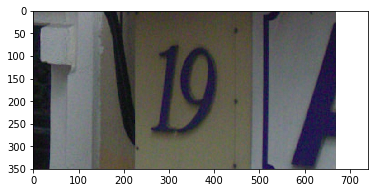

In [24]:
#Just testing with first image to see how it looks.
img = plt.imread("./svhn/train/1.png")
plt.imshow(img)
plt.show("./svhn/train/1.png")

In [25]:
file_ = os.path.join(train_folder, 'digitStruct.mat')
dsf = DigitStructsWrapper(file_)
train_data = dsf.getAllNumbersRestructured()


./svhn/train/digitStruct.mat file structure contain 33402 entries

Object structure before transforming:  {'name': '1.png', 'height': [219.0, 219.0], 'width': [81.0, 96.0], 'left': [246.0, 323.0], 'label': [1.0, 9.0], 'top': [77.0, 81.0]}

Dataset size before update: 33402

Anomaly at index 29929 detected. Class size: 6
{'name': '29930.png', 'height': [18.0, 18.0, 18.0, 18.0, 18.0, 18.0], 'width': [5.0, 6.0, 8.0, 10.0, 9.0, 8.0], 'left': [18.0, 24.0, 30.0, 37.0, 48.0, 56.0], 'label': [1.0, 3.0, 5.0, 4.0, 5.0, 8.0], 'top': [3.0, 3.0, 4.0, 3.0, 4.0, 4.0]}

Dataset after before update: 33401

Object structure after transforming:  {'name': '1.png', 'boxes': [{'width': 81.0, 'top': 77.0, 'left': 246.0, 'label': 1.0, 'height': 219.0}, {'width': 96.0, 'top': 81.0, 'left': 323.0, 'label': 9.0, 'height': 219.0}]}


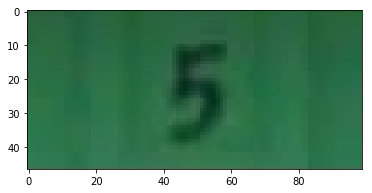

In [26]:
img = plt.imread("./svhn/test/1.png")
plt.imshow(img)

In [27]:
file_ = os.path.join(test_folder, 'digitStruct.mat')
dsf = DigitStructsWrapper(file_)
test_data = dsf.getAllNumbersRestructured()


./svhn/test/digitStruct.mat file structure contain 13068 entries

Object structure before transforming:  {'name': '1.png', 'height': [30.0], 'width': [19.0], 'left': [43.0], 'label': [5.0], 'top': [7.0]}

Dataset size before update: 13068

Dataset after before update: 13068

Object structure after transforming:  {'name': '1.png', 'boxes': [{'width': 19.0, 'top': 7.0, 'left': 43.0, 'label': 5.0, 'height': 30.0}]}


In [28]:
file_ = os.path.join(extra_folder, 'digitStruct.mat')
dsf = DigitStructsWrapper(file_, 0, 50000)
extra_data = dsf.getAllNumbersRestructured()


./svhn/extra/digitStruct.mat file structure contain 50000 entries

Object structure before transforming:  {'name': '1.png', 'height': [56.0, 56.0, 56.0], 'width': [38.0, 36.0, 47.0], 'left': [24.0, 55.0, 79.0], 'label': [4.0, 7.0, 8.0], 'top': [70.0, 41.0, 23.0]}

Dataset size before update: 50000

Dataset after before update: 50000

Object structure after transforming:  {'name': '1.png', 'boxes': [{'width': 38.0, 'top': 70.0, 'left': 24.0, 'label': 4.0, 'height': 56.0}, {'width': 36.0, 'top': 41.0, 'left': 55.0, 'label': 7.0, 'height': 56.0}, {'width': 47.0, 'top': 23.0, 'left': 79.0, 'label': 8.0, 'height': 56.0}]}


In [29]:
a = np.ndarray([5,2])
np.arange(5)
train_data[1]['name']
from PIL import Image
Image.open("./svhn/train/1.png").size[:]
a[0,:] = Image.open("./svhn/train/1.png").size[:]
a[1,:] = Image.open("./svhn/train/2.png").size[:]
a[2,:] = Image.open("./svhn/train/9748.png").size[:]
a[3,:] = Image.open("./svhn/train/15856.png").size[:]
a[4,:] = Image.open("./svhn/train/4164.png").size[:]
a

array([[ 741.,  350.],
       [ 199.,   83.],
       [  25.,   12.],
       [ 876.,  501.],
       [ 876.,  206.]])

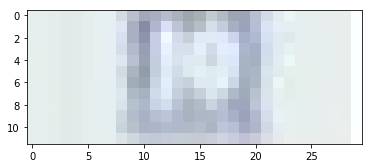

In [30]:
file_name = os.path.join(train_folder,train_data[15855]['name'])
img = plt.imread(file_name)
plt.imshow(img)
file_name = os.path.join(train_folder,train_data[4829]['name'])
img = plt.imread(file_name)
plt.imshow(img)

In [31]:
from PIL import Image

def print_data_stats(data, folder):
    data_imgSize = np.ndarray([len(data),2])

    for i in np.arange(len(data)):
        filename = data[i]['name']
        filepath = os.path.join(folder, filename)
        data_imgSize[i, :] = Image.open(filepath).size[:]

    max_w, max_h = np.amax(data_imgSize[:,0]), np.amax(data_imgSize[:,1])
    min_w, min_h = np.amin(data_imgSize[:,0]), np.amin(data_imgSize[:,1])
    mean_w, mean_h = np.mean(data_imgSize[:,0]), np.mean(data_imgSize[:,1])
    print(folder, "max width and height:", max_w, max_h) 
    print(folder, "min width and height:", min_w, min_h)
    print(folder, "mean width and height:", mean_w, mean_h, "\n")
    
    max_w_i, max_h_i = np.where(data_imgSize[:,0] == max_w), np.where(data_imgSize[:,1] == max_h)
    print(folder, "max width indicies:", max_w_i) 
    print(folder, "max height indicies:", max_h_i, "\n")
    
    
    min_w_i, min_h_i = np.where(data_imgSize[:,0] == min_w), np.where(data_imgSize[:,1] == min_h)
    print(folder, "min width indicies:", min_w_i) 
    print(folder, "min height indicies:", min_h_i, "\n***\n")

In [32]:
print_data_stats(train_data, train_folder)
print_data_stats(test_data, test_folder)
print_data_stats(extra_data, extra_folder)

./svhn/train max width and height: 876.0 501.0
./svhn/train min width and height: 25.0 12.0
./svhn/train mean width and height: 128.286338732 57.2139456902 

./svhn/train max width indicies: (array([  410,  4163, 15855, 30483]),)
./svhn/train max height indicies: (array([15855]),) 

./svhn/train min width indicies: (array([9747]),)
./svhn/train min height indicies: (array([ 1813,  2291,  4829,  5691,  9488,  9747,  9831, 10175, 10938,
       14902, 16284, 20314, 20775, 21544, 22330, 24015, 25438, 26047,
       26345, 27062, 27160, 27593, 27959, 29526, 29701, 30064, 30089,
       30462, 30947, 32339, 32351, 32539, 32567, 33141, 33180, 33202]),) 
***

./svhn/test max width and height: 1083.0 516.0
./svhn/test min width and height: 31.0 13.0
./svhn/test mean width and height: 172.583486379 71.5664983165 

./svhn/test max width indicies: (array([ 1722,  2949,  6233, 12862]),)
./svhn/test max height indicies: (array([14]),) 

./svhn/test min width indicies: (array([  459,  5352,  7776, 1125

In [33]:
img_size = 32

def prepare_images(samples, folder):
    print("Started preparing images for convnet...")
    
    prepared_images = np.ndarray([len(samples),img_size,img_size,1], dtype='float32')
    actual_numbers = np.ones([len(samples),6], dtype=int) * 10
    files = []
    for i in range(len(samples)):
        filename = samples[i]['name']
        filepath = os.path.join(folder, filename)
        image = Image.open(filepath)
        boxes = samples[i]['boxes']
        number_length = len(boxes)
        files.append(filename)
        
        # at 0 index we store length of a label. 3 -> 1; 123-> 3, 12543 -> 5
        actual_numbers[i,0] = number_length
        
        top = np.ndarray([number_length], dtype='float32')
        left = np.ndarray([number_length], dtype='float32')
        height = np.ndarray([number_length], dtype='float32')
        width = np.ndarray([number_length], dtype='float32')
        
        for j in range(number_length):
            # here we use j+1 since first entry used by label length
            actual_numbers[i,j+1] = boxes[j]['label']
            if boxes[j]['label'] == 10: # Replacing 10 with 0
                actual_numbers[i,j+1] = 0
                
            top[j] = boxes[j]['top']
            left[j] = boxes[j]['left']
            height[j] = boxes[j]['height']
            width[j] = boxes[j]['width']
        
        img_min_top = np.amin(top)
        img_min_left = np.amin(left)
        img_height = np.amax(top) + height[np.argmax(top)] - img_min_top
        img_width = np.amax(left) + width[np.argmax(left)] - img_min_left

        img_left = np.floor(img_min_left - 0.1 * img_width)
        img_top = np.floor(img_min_top - 0.1 * img_height)
        img_right = np.amin([np.ceil(img_left + 1.2 * img_width), image.size[0]])
        img_bottom = np.amin([np.ceil(img_top + 1.2 * img_height), image.size[1]])
            
        image = image.crop((img_left, img_top, img_right, img_bottom)).resize([img_size, img_size], Image.ANTIALIAS) # Resize image to 32x32
        image = np.dot(np.array(image, dtype='float32'), [[0.2989],[0.5870],[0.1140]]) # Convert image to the grayscale

        mean = np.mean(image, dtype='float32')
        std = np.std(image, dtype='float32', ddof=1)
        if std < 0.0001: 
            std = 1.0
        image = (image - mean) / std
        prepared_images[i,:,:] = image[:,:,:]
        
    print("Completed. Images cropped, resized and grayscaled")
    
    return prepared_images, actual_numbers, files

In [34]:
train_data, train_labels, _ = prepare_images(train_data, train_folder)
print(train_data.shape, train_labels.shape)

Started preparing images for convnet...
Completed. Images cropped, resized and grayscaled
(33401, 32, 32, 1) (33401, 6)


In [35]:
np.amin(train_data[0])
train_labels[0]

array([ 2,  1,  9, 10, 10, 10])

In [36]:
test_data, test_labels, test_filenames = prepare_images(test_data, test_folder)
print(test_data.shape, test_labels.shape)

Started preparing images for convnet...
Completed. Images cropped, resized and grayscaled
(13068, 32, 32, 1) (13068, 6)


In [37]:
np.amin(train_data[0])
test_labels[0]

array([ 1,  5, 10, 10, 10, 10])

In [38]:
extra_data, extra_labels, _ = prepare_images(extra_data, extra_folder)
print(extra_data.shape, extra_data.shape)

Started preparing images for convnet...
Completed. Images cropped, resized and grayscaled
(50000, 32, 32, 1) (50000, 32, 32, 1)


In [39]:
print(extra_labels[:10])

[[ 3  4  7  8 10 10]
 [ 2  7  1 10 10 10]
 [ 3  1  7  4 10 10]
 [ 2  3  0 10 10 10]
 [ 3  2  8  8 10 10]
 [ 2  3  1 10 10 10]
 [ 3  1  7  0 10 10]
 [ 2  8  1 10 10 10]
 [ 2  5  6 10 10 10]
 [ 3  4  4  4 10 10]]


In [40]:
from sklearn.utils import shuffle

# Here we add new data to our training set from extra set.
# Then we remove this part from memory to free it
train_data_temp = np.concatenate((train_data, extra_data[:40000, :, :, :]))
extra_data_temp = np.delete(extra_data, np.arange(40000), axis=0)

train_labels_temp = np.concatenate((train_labels, extra_labels[:40000]))
extra_labels_temp = np.delete(extra_labels, np.arange(40000), axis=0)

# And then we shuffle all the data we have
train_data_temp, train_labels_temp = shuffle(train_data_temp, train_labels_temp)
extra_data_temp, extra_labels_temp = shuffle(extra_data_temp, extra_labels_temp)
test_data_temp, test_labels_temp, test_filenames_temp = shuffle(test_data, test_labels, test_filenames)

print("\nTrain shapes:", train_data_temp.shape, train_labels_temp.shape)
print("Extra shapes:", extra_data_temp.shape, extra_labels_temp.shape)
print("Test shapes:", test_data_temp.shape, test_labels_temp.shape)


Train shapes: (73401, 32, 32, 1) (73401, 6)
Extra shapes: (10000, 32, 32, 1) (10000, 6)
Test shapes: (13068, 32, 32, 1) (13068, 6)


In [41]:
pickle_file = './svhn/SVHN.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_data': train_data_temp,
        'train_labels': train_labels_temp,
        'test_data': test_data_temp,
        'test_labels': test_labels_temp,
        'test_filenames': test_filenames_temp,
        'valid_data': extra_data_temp, # The rest of extra data will be used 
        'valid_labels': extra_labels_temp # as validation set during model training
        }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 399913844


In [42]:
from collections import Counter

train_num_length = Counter(train_labels_temp[:,0])
test_num_length = Counter(test_labels_temp[:,0])
extra_num_length = Counter(extra_labels_temp[:,0])

##### Plotting the data to view number of digits in training, test and extra data

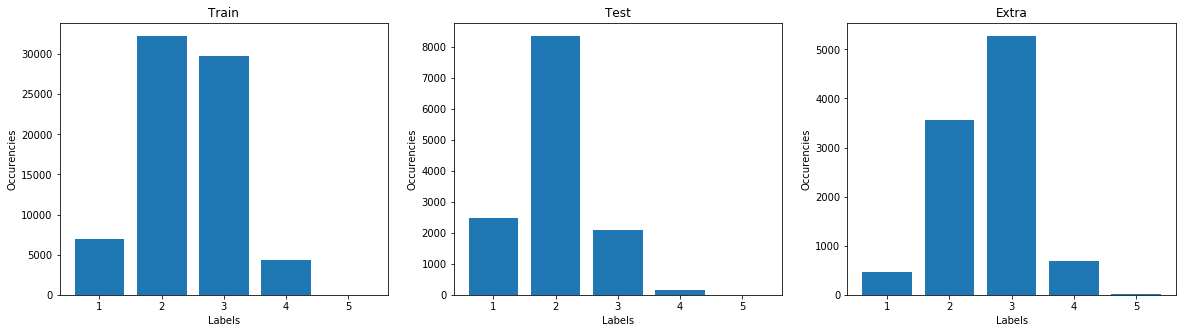

In [44]:
import matplotlib.pyplot as plt

f, (plt1, plt2, plt3) = plt.subplots(1, 3, figsize=(20, 5))

#plt1.subplot(221)
plt1.bar(list(train_num_length.keys()), list(train_num_length.values()), align='center')
plt1.set_xticks(list(train_num_length.keys()))
plt1.set_title('Train')
plt1.set_xlabel('Labels')
plt1.set_ylabel('Occurencies')

#plt2.subplot(222)
plt2.bar(list(test_num_length.keys()), list(test_num_length.values()), align='center')
plt2.set_xticks(list(test_num_length.keys()))
plt2.set_title('Test')
plt2.set_xlabel('Labels')
plt2.set_ylabel('Occurencies')

#plt3.subplot(223)
plt3.bar(list(extra_num_length.keys()), list(extra_num_length.values()), align='center')
plt3.set_xticks(list(test_num_length.keys()))
plt3.set_title('Extra')
plt3.set_xlabel('Labels')
plt3.set_ylabel('Occurencies')

#plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.50,
#                    wspace=0.35)

plt.show()

In [45]:
pickle_file = './svhn/SVHN.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_labels = save['train_labels']
    test_labels = save['test_labels']
    valid_labels = save['valid_labels']
    del save

In [46]:
from collections import Counter

# Remove classes of empty labels
train_digits = Counter(train_labels[:,1:6].flatten()[np.where(train_labels[:,1:6].flatten() != 10)])
test_digits = Counter(test_labels[:,1:6].flatten()[np.where(test_labels[:,1:6].flatten() != 10)])
valid_digits = Counter(valid_labels[:,1:6].flatten()[np.where(valid_labels[:,1:6].flatten() != 10)])

In [47]:
list(train_digits.values())

[14100, 31866, 25224, 20491, 17448, 17498, 13976, 14290, 11972, 11427]

#### Plotting to view which digit occurs how many times

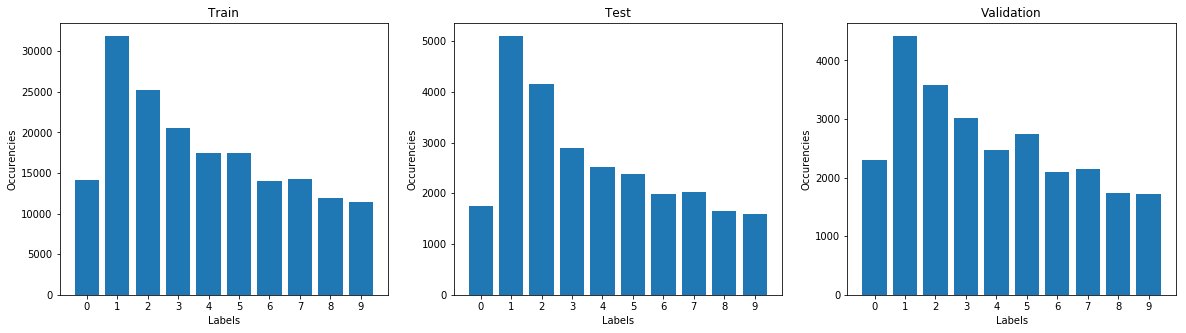

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

ax1.bar(list(train_digits.keys()), list(train_digits.values()), align='center')
ax1.set_xticks(list(train_digits.keys()))
ax1.set_title('Train')
ax1.set_xlabel('Labels')
ax1.set_ylabel('Occurencies')

ax2.bar(list(test_digits.keys()), list(test_digits.values()), align='center')
ax2.set_xticks(list(test_digits.keys()))
ax2.set_title('Test')
ax2.set_xlabel('Labels')
ax2.set_ylabel('Occurencies')

ax3.bar(list(valid_digits.keys()), list(valid_digits.values()), align='center')
ax3.set_xticks(list(valid_digits.keys()))
ax3.set_title('Validation')
ax3.set_xlabel('Labels')
ax3.set_ylabel('Occurencies')

plt.show()

### Implementation of CNN (Convolutional Neural Network) for [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset

In [3]:
pickle_file = './svhn/SVHN.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_data']
    train_labels = save['train_labels']
    test_dataset = save['test_data']
    test_labels = save['test_labels']
    test_filenames = save['test_filenames']
    valid_dataset = save['valid_data']
    valid_labels = save['valid_labels']
    del save
    
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (73401, 32, 32, 1) (73401, 6)
Validation set (10000, 32, 32, 1) (10000, 6)
Test set (13068, 32, 32, 1) (13068, 6)


In [4]:
def gaussian_filter(kernel_shape):
    x = np.zeros(kernel_shape, dtype = float)
    mid = np.floor(kernel_shape[0] / 2.)
    
    for kernel_idx in range(0, kernel_shape[2]):
        for i in range(0, kernel_shape[0]):
            for j in range(0, kernel_shape[1]):
                x[i, j, kernel_idx, 0] = gauss(i - mid, j - mid)
    
    return tf.convert_to_tensor(x / np.sum(x), dtype=tf.float32)

In [5]:
def gauss(x, y, sigma=3.0):
    Z = 2 * np.pi * sigma ** 2
    return  1. / Z * np.exp(-(x ** 2 + y ** 2) / (2. * sigma ** 2))

In [6]:
def LecunLCN(X, image_shape, threshold=1e-4, radius=7, use_divisor=True):
    """Local Contrast Normalization"""
    """[http://yann.lecun.com/exdb/publis/pdf/jarrett-iccv-09.pdf]"""

    # Get Gaussian filter
    filter_shape = (radius, radius, image_shape[3], 1)

    #self.filters = theano.shared(self.gaussian_filter(filter_shape), borrow=True)
    filters = gaussian_filter(filter_shape)
    X = tf.convert_to_tensor(X, dtype=tf.float32)
    # Compute the Guassian weighted average by means of convolution
    convout = tf.nn.conv2d(X, filters, [1,1,1,1], 'SAME')

    # Subtractive step
    mid = int(np.floor(filter_shape[1] / 2.))

    # Make filter dimension broadcastable and subtract
    centered_X = tf.subtract(X, convout)

    # Boolean marks whether or not to perform divisive step
    if use_divisor:
        # Note that the local variances can be computed by using the centered_X
        # tensor. If we convolve this with the mean filter, that should give us
        # the variance at each point. We simply take the square root to get our
        # denominator

        # Compute variances
        sum_sqr_XX = tf.nn.conv2d(tf.square(centered_X), filters, [1,1,1,1], 'SAME')

        # Take square root to get local standard deviation
        denom = tf.sqrt(sum_sqr_XX)

        per_img_mean = tf.reduce_mean(denom)
        divisor = tf.maximum(per_img_mean, denom)
        # Divisise step
        new_X = tf.truediv(centered_X, tf.maximum(divisor, threshold))
    else:
        new_X = centered_X
    return new_X

In [7]:
def accuracy(predictions, labels, printstat=False):
    return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] / predictions.shape[0])

In [8]:
image_size = 32
num_labels = 11 # 0-9, + blank 
num_channels = 1 # grayscale

batch_size = 64
patch_size = 5
depth1 = 32
depth2 = 64
depth3 = 128
num_hidden1 = 512
num_hidden2 = 128
num_hidden3 = 32
shape = [batch_size, image_size, image_size, num_channels]

#Input: batch_size x 32 x 32 x 1
#C1: convolutional layer, batch_size x 28 x 28 x 32, filter size: 5 x 5 x 1 x 32
#P2: pooling layer, batch_size x 14 x 14 x 32
#C3: convolutional layer, batch_size x 10 x 10 x 64, filter size: 5 x 5 x 32 x 64
#P4: pooling layer, batch_size x 5 x 5 x 64
#C5: convolutional layer, batch_size x 1 x 1 x 512, filter size: 5 x 5 x 64 x 512
#Dropout
#F6: fully-connected layer 1, weight size: batch_size x 512
#F7: fully-connected layer 2, weight size: batch_size x 128
#F8: fully-connected layer 3, weight size: batch_size x 32
#Output layer, weight size: batch_size x 11

train_size = train_labels.shape[0]

graph = tf.Graph()
with graph.as_default():

    # Input data placeholders.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    #tf_test_dataset = tf.placeholder(tf.float32, shape=(None, image_size, image_size, num_channels))
  
    # Variables.
    layer1_weights = tf.get_variable("W1", shape=[patch_size, patch_size, num_channels, depth1],\
                                     initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer1_biases = tf.Variable(tf.constant(1.0, shape=[depth1]), name='B1')
    
    layer2_weights = tf.get_variable("W2", shape=[patch_size, patch_size, depth1, depth2],\
                                     initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]), name='B2')
    
    layer3_weights = tf.get_variable("W3", shape=[patch_size, patch_size, depth2, num_hidden1],\
                                     initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden1]), name='B3')

    s1_w1 = tf.get_variable("WS11", shape=[num_hidden1, num_hidden2],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s1_b1 = tf.Variable(tf.constant(1.0, shape=[num_hidden2]), name='BS11')
    
    s2_w1 = tf.get_variable("WS12", shape=[num_hidden1, num_hidden2],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s2_b1 = tf.Variable(tf.constant(1.0, shape=[num_hidden2]), name='BS12')
    
    s3_w1 = tf.get_variable("WS13", shape=[num_hidden1, num_hidden2],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s3_b1 = tf.Variable(tf.constant(1.0, shape=[num_hidden2]), name='BS13')
    
    s4_w1 = tf.get_variable("WS14", shape=[num_hidden1, num_hidden2],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s4_b1 = tf.Variable(tf.constant(1.0, shape=[num_hidden2]), name='BS14')
    
    s5_w1 = tf.get_variable("WS15", shape=[num_hidden1, num_hidden2],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s5_b1 = tf.Variable(tf.constant(1.0, shape=[num_hidden2]), name='BS15')
    

    s1_w2 = tf.get_variable("WS21", shape=[num_hidden2, num_hidden3],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s1_b2 = tf.Variable(tf.constant(1.0, shape=[num_hidden3]), name='BS21')
    
    s2_w2 = tf.get_variable("WS22", shape=[num_hidden2, num_hidden3],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s2_b2 = tf.Variable(tf.constant(1.0, shape=[num_hidden3]), name='BS22')
    
    s3_w2 = tf.get_variable("WS23", shape=[num_hidden2, num_hidden3],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s3_b2 = tf.Variable(tf.constant(1.0, shape=[num_hidden3]), name='BS23')
    
    s4_w2 = tf.get_variable("WS24", shape=[num_hidden2, num_hidden3],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s4_b2 = tf.Variable(tf.constant(1.0, shape=[num_hidden3]), name='BS24')
    
    s5_w2 = tf.get_variable("WS25", shape=[num_hidden2, num_hidden3],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s5_b2 = tf.Variable(tf.constant(1.0, shape=[num_hidden3]), name='BS25')
    

    s1_w3 = tf.get_variable("WS31", shape=[num_hidden3, num_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s1_b3 = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS31')
    
    s2_w3 = tf.get_variable("WS32", shape=[num_hidden3, num_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s2_b3 = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS32')
    
    s3_w3 = tf.get_variable("WS33", shape=[num_hidden3, num_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s3_b3 = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS33')
    
    s4_w3 = tf.get_variable("WS34", shape=[num_hidden3, num_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s4_b3 = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS34')
    
    s5_w3 = tf.get_variable("WS35", shape=[num_hidden3, num_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s5_b3 = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS35')

    # Model.
    def model(data, keep_prob, shape):
        LCN = LecunLCN(data, shape)
        
        conv = tf.nn.conv2d(LCN, layer1_weights, [1,1,1,1], 'VALID', name='C1')
        hidden = tf.nn.relu(conv + layer1_biases)
        lrn = tf.nn.local_response_normalization(hidden)
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='P2')
        
        conv = tf.nn.conv2d(sub, layer2_weights, [1,1,1,1], padding='VALID', name='C3')
        hidden = tf.nn.relu(conv + layer2_biases)
        lrn = tf.nn.local_response_normalization(hidden)
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='P4')
        
        conv = tf.nn.conv2d(sub, layer3_weights, [1,1,1,1], padding='VALID', name='C5')        
        hidden = tf.nn.relu(conv + layer3_biases)
        hidden = tf.nn.dropout(hidden, keep_prob)
        
        shape = hidden.get_shape().as_list()
        print ("shape is: ", shape)
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        print("after reshape: ", reshape.get_shape())
        # hidden = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)
        hidden11 = tf.nn.relu(tf.matmul(reshape, s1_w1) + s1_b1)
        hidden21 = tf.nn.relu(tf.matmul(reshape, s2_w1) + s2_b1)
        hidden31 = tf.nn.relu(tf.matmul(reshape, s3_w1) + s3_b1)
        hidden41 = tf.nn.relu(tf.matmul(reshape, s4_w1) + s4_b1)
        hidden51 = tf.nn.relu(tf.matmul(reshape, s5_w1) + s5_b1)
        
        print ("hidden11 shape: ", hidden11.shape)
        
        hidden12 = tf.nn.relu(tf.matmul(hidden11, s1_w2) + s1_b2)
        hidden22 = tf.nn.relu(tf.matmul(hidden21, s2_w2) + s2_b2)
        hidden32 = tf.nn.relu(tf.matmul(hidden31, s3_w2) + s3_b2)
        hidden42 = tf.nn.relu(tf.matmul(hidden41, s4_w2) + s4_b2)
        hidden52 = tf.nn.relu(tf.matmul(hidden51, s5_w2) + s5_b2)
        
        print ("hidden12 shape: ", hidden12.shape)
        
        logits1 = tf.matmul(hidden12, s1_w3) + s1_b3
        logits2 = tf.matmul(hidden22, s2_w3) + s2_b3
        logits3 = tf.matmul(hidden32, s3_w3) + s3_b3
        logits4 = tf.matmul(hidden42, s4_w3) + s4_b3
        logits5 = tf.matmul(hidden52, s5_w3) + s5_b3
        
        return [logits1, logits2, logits3, logits4, logits5]

    # Training computation.
    [logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset, 0.6, shape)
    print ("logits1 shape: ",logits1.shape)
    print (logits1[0])
    print (tf_train_labels[:,1][0])
    print (logits2.shape)
    print (logits3.shape)
    print (logits4.shape)
    print (logits5.shape)
    
    # L2 regularization for the fully connected parameters.
    regularizers = [(tf.nn.l2_loss(s1_w2) + tf.nn.l2_loss(s1_b2)),
                    (tf.nn.l2_loss(s2_w2) + tf.nn.l2_loss(s2_b2)),
                    (tf.nn.l2_loss(s3_w2) + tf.nn.l2_loss(s3_b2)),
                    (tf.nn.l2_loss(s4_w2) + tf.nn.l2_loss(s4_b2)),
                    (tf.nn.l2_loss(s5_w2) + tf.nn.l2_loss(s5_b2)),]
    
    post_logits = [tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits1, labels=tf_train_labels[:,1])),
                   tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits2, labels=tf_train_labels[:,2])),
                   tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits3, labels=tf_train_labels[:,3])),
                   tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits4, labels=tf_train_labels[:,4])),
                   tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits5, labels=tf_train_labels[:,5]))]
    
    loss = (post_logits[0] + 4e-4 * regularizers[0]) + (post_logits[1] + 4e-4 * regularizers[1]) + \
           (post_logits[2] + 4e-4 * regularizers[2]) + (post_logits[3] + 4e-4 * regularizers[3]) + \
           (post_logits[4] + 4e-4 * regularizers[4])
    
    # Optimizer.
    batch = tf.Variable(0, dtype=tf.float32)
    
    # Decay once per epoch, using an exponential schedule starting at 0.01.
    learning_rate = tf.train.exponential_decay(0.01, batch * batch_size, train_size, 0.95, staircase=True)
    
    # Use simple momentum for the optimization.
    optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9).minimize(loss, global_step=batch)
    
    # Predictions for the training, validation and test data.
    train_logits = model(tf_train_dataset, 1.0, shape)
    train_prediction = tf.stack([tf.nn.softmax(train_logits[0]), tf.nn.softmax(train_logits[1]),\
                                tf.nn.softmax(train_logits[2]), tf.nn.softmax(train_logits[3]),\
                                tf.nn.softmax(train_logits[4])])
    
    valid_logits = model(tf_valid_dataset, 1.0, shape)
    valid_prediction = tf.stack([tf.nn.softmax(valid_logits[0]), tf.nn.softmax(valid_logits[1]),\
                                tf.nn.softmax(valid_logits[2]), tf.nn.softmax(valid_logits[3]),\
                                tf.nn.softmax(valid_logits[4])])
    
    
    test_logits = model(tf_test_dataset, 1.0, shape)
    test_prediction = tf.stack([tf.nn.softmax(test_logits[0]), tf.nn.softmax(test_logits[1]),\
                               tf.nn.softmax(test_logits[2]), tf.nn.softmax(test_logits[3]),\
                               tf.nn.softmax(test_logits[4])])
    final_test_prediction = tf.transpose(tf.argmax(test_prediction, 2))

    saver = tf.train.Saver()

shape is:  [64, 1, 1, 512]
after reshape:  (64, 512)
hidden11 shape:  (64, 128)
hidden12 shape:  (64, 32)
logits1 shape:  (64, 11)
Tensor("strided_slice:0", shape=(11,), dtype=float32)
Tensor("strided_slice_2:0", shape=(), dtype=int32)
(64, 11)
(64, 11)
(64, 11)
(64, 11)
shape is:  [64, 1, 1, 512]
after reshape:  (64, 512)
hidden11 shape:  (64, 128)
hidden12 shape:  (64, 32)
shape is:  [10000, 1, 1, 512]
after reshape:  (10000, 512)
hidden11 shape:  (10000, 128)
hidden12 shape:  (10000, 32)
shape is:  [13068, 1, 1, 512]
after reshape:  (13068, 512)
hidden11 shape:  (13068, 128)
hidden12 shape:  (13068, 32)


#### Training the model

Training the model and saving the model as svhn.convnet.

In [ ]:
num_steps = 25001
#num_steps = 4000

loss_values = []
train_accuracies = []
validation_accuracies = []

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()  
    print('Initialized')
    
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size),:]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        #print ("prediction shape: ", predictions.shape)
        #print ("first prediction: ", predictions[:,0:1,:])
        #print ("label is: ", test_labels[:,1:6][0])
        #print ("prediction is: ", np.argmax(predictions[:,0:1,:], 2).T)
        
    
        #if step % 10 == 0:
        #    loss_values.append(l)
            
        if (step % 1000 == 0): 
            train_accuracy = accuracy(predictions, batch_labels[:,1:6])
            valid_accuracy = accuracy(valid_prediction.eval(), valid_labels[:,1:6])
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % train_accuracy)    
            print('Validation accuracy: %.1f%%' % valid_accuracy)
            train_accuracies.append(train_accuracy)
            validation_accuracies.append(valid_accuracy)
            
    
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:6]))
    #print ('Prediction is: ', final_test_prediction.eval()[1:11])
    #print ("label is: ", test_labels[:,0:6])
    #print ("prediction is: ", np.argmax(test_prediction.eval(), 2).T)
    
    save_path = saver.save(session, "svhn.convnet")
    print("Model saved in file: %s" % save_path)

Initialized
Minibatch loss at step 0: 24.176895
Minibatch accuracy: 2.2%
Validation accuracy: 49.9%
Minibatch loss at step 1000: 6.165755
Minibatch accuracy: 60.0%
Validation accuracy: 57.3%
Minibatch loss at step 2000: 3.323462
Minibatch accuracy: 83.1%
Validation accuracy: 80.5%
Minibatch loss at step 3000: 1.936017
Minibatch accuracy: 90.6%
Validation accuracy: 88.9%
Minibatch loss at step 4000: 2.159056
Minibatch accuracy: 90.3%
Validation accuracy: 91.5%
Minibatch loss at step 5000: 0.719679
Minibatch accuracy: 96.9%
Validation accuracy: 92.8%
Minibatch loss at step 6000: 1.624583
Minibatch accuracy: 93.4%
Validation accuracy: 93.4%
Minibatch loss at step 7000: 1.242321
Minibatch accuracy: 95.6%
Validation accuracy: 94.2%
Minibatch loss at step 8000: 0.989335
Minibatch accuracy: 94.4%
Validation accuracy: 94.5%
Minibatch loss at step 9000: 0.706738
Minibatch accuracy: 97.2%
Validation accuracy: 94.7%
Minibatch loss at step 10000: 0.995443
Minibatch accuracy: 95.0%
Validation accur

## Testing the model

From Test dataset, selecting 10 random images to test the saved model out. Saving 10 random images into list called im_samples.

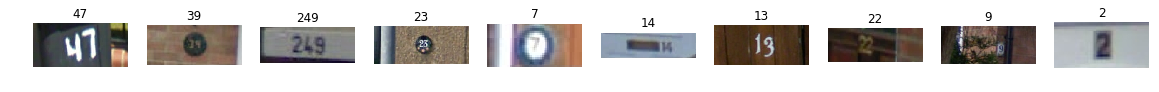

In [9]:
from PIL import Image
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=1, ncols=10)

im_samples = []
for i, item in enumerate(np.sort(np.random.randint(0, test_labels.shape[0], size=10))):
    filename = test_filenames[item]
    fullname = os.path.join('./svhn/test', filename)
    im = Image.open(fullname)
    house_num = ''
    for k in np.arange(test_labels[item,0]):
        house_num += str(test_labels[item,k+1])
        
    im_samples.extend([item])
    ax[i].axis('off')
    ax[i].set_title(house_num, loc='center')
    ax[i].imshow(im)

### Running the saved model against 10 randomly picked images

In [10]:
with tf.Session(graph=graph) as session:
    #tf.global_variables_initializer().run()
    saver = tf.train.import_meta_graph('./svhn.convnet.meta')    
    saver.restore(session, './svhn.convnet')
    print("Model restored.")  
    
    print('Initialized')
    tf_test_dataset_1 = tf.constant(test_dataset[im_samples,:,:,:])
    test_logits_1 = model(tf_test_dataset_1, 1.0, shape)
    test_prediction_1 = tf.stack([tf.nn.softmax(test_logits_1[0]), tf.nn.softmax(test_logits_1[1]),\
                               tf.nn.softmax(test_logits_1[2]), tf.nn.softmax(test_logits_1[3]),\
                               tf.nn.softmax(test_logits_1[4])])
    final_test_prediction_1 = tf.transpose(tf.argmax(test_prediction_1, 2))
    #test_prediction = session.run(test_prediction, feed_dict={tf_test_dataset : test_dataset[im_samples,:,:,:],})
    #predict,test_prediction = session.run([predict,test_prediction], feed_dict={tf_test_dataset : test_dataset[im_samples,:,:,:],})
    #print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:6]))
    #print ('Prediction is: ', final_test_prediction.eval()[11:21])
    final_test_prediction_1 = final_test_prediction_1.eval()
    #print ("new test prediction is: ", final_test_prediction_1)
    #print(test_prediction)
    #print (predict)
    #print('Test accuracy: %.1f%%' % accuracy(predict, test_labels[im_samples,1:6]))

Model restored.
Initialized
shape is:  [10, 1, 1, 512]
after reshape:  (10, 512)
hidden11 shape:  (10, 128)
hidden12 shape:  (10, 32)


### Comparing actual labels against predicted labels

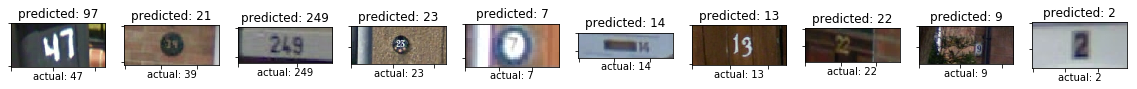

In [11]:
plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=1, ncols=10)

for i, j in enumerate(im_samples):
    filename = test_filenames[j]
    fullname = os.path.join('./svhn/test', filename)
    im = Image.open(fullname)
    house_num = ''
    for k in np.arange(test_labels[j,0]):
        house_num += str(test_labels[j,k+1])
    
    house_num_predicted = ''
    for k in np.arange(np.sum(final_test_prediction_1[i,:] != 10)):
        house_num_predicted += str(final_test_prediction_1[i,k])

    #ax[i].axis('off')
    ax[i].set_title("predicted: "+house_num_predicted, loc='center')
    ax[i].set_xlabel("actual: "+house_num)
    ax[i].tick_params(labelbottom='off')
    ax[i].tick_params(labelleft='off')
    ax[i].imshow(im)

### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

**Answer:**

Training and Testing data was set up using SVHN dataset. Following steps were taken to create training and test dataset -
1. I first downloaded and extracted training, test and extra images dataset to my computer.

2. I removed all the images that has number of digits more than 5.

3. I downloaded the metadata file that has information on height, width and length of actual street number in the images. Using the meta data, I cropped the images to get rid of surrounding noise in the images.

4. Upon cropping the image, I resized (to 32 by 32), grayscaled and normalized such that it could be fed into Convnet.

5. Since there were less training data, I added 40000 additional images from extra dataset to training data set.

Model worked pretty well on Test dataset. I got almost 96% of accuracy with test dataset.

### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

**Answer:**

Quite a few things help with performance and accuracy -

1. First of all, I moved from CPU to GPU machines. That improved training performance almost 10 times. When I moved to GPU machine, initailly GPU was not getting picked up by Tensorflow. I had to spend quite a bit of time to figure out exact issue - I had to get the right Nvidia GPU driver version for tensor flow to work with GPU.

2. Cropping and Normalization of images helped with accuracy and performance a lot.

3. Batch size and number of training steps helped me with performance and accuracy optimzation. I got the best accuracy with batch size 0f 64 (also tried 128 and 256).



### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

**Answer:**

In order to test with realistic data, I went around and captured multiple images of street name using my camera. I ran the model on those images. As you can see below, model did pretty good with captured images.

Although for model to work well, it's important that images are cropped properly. A future project will be to figure out how to automatically crop image such that less manaul intervention is needed.

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

##### Took some pictures using my camera and running the model against those pictures

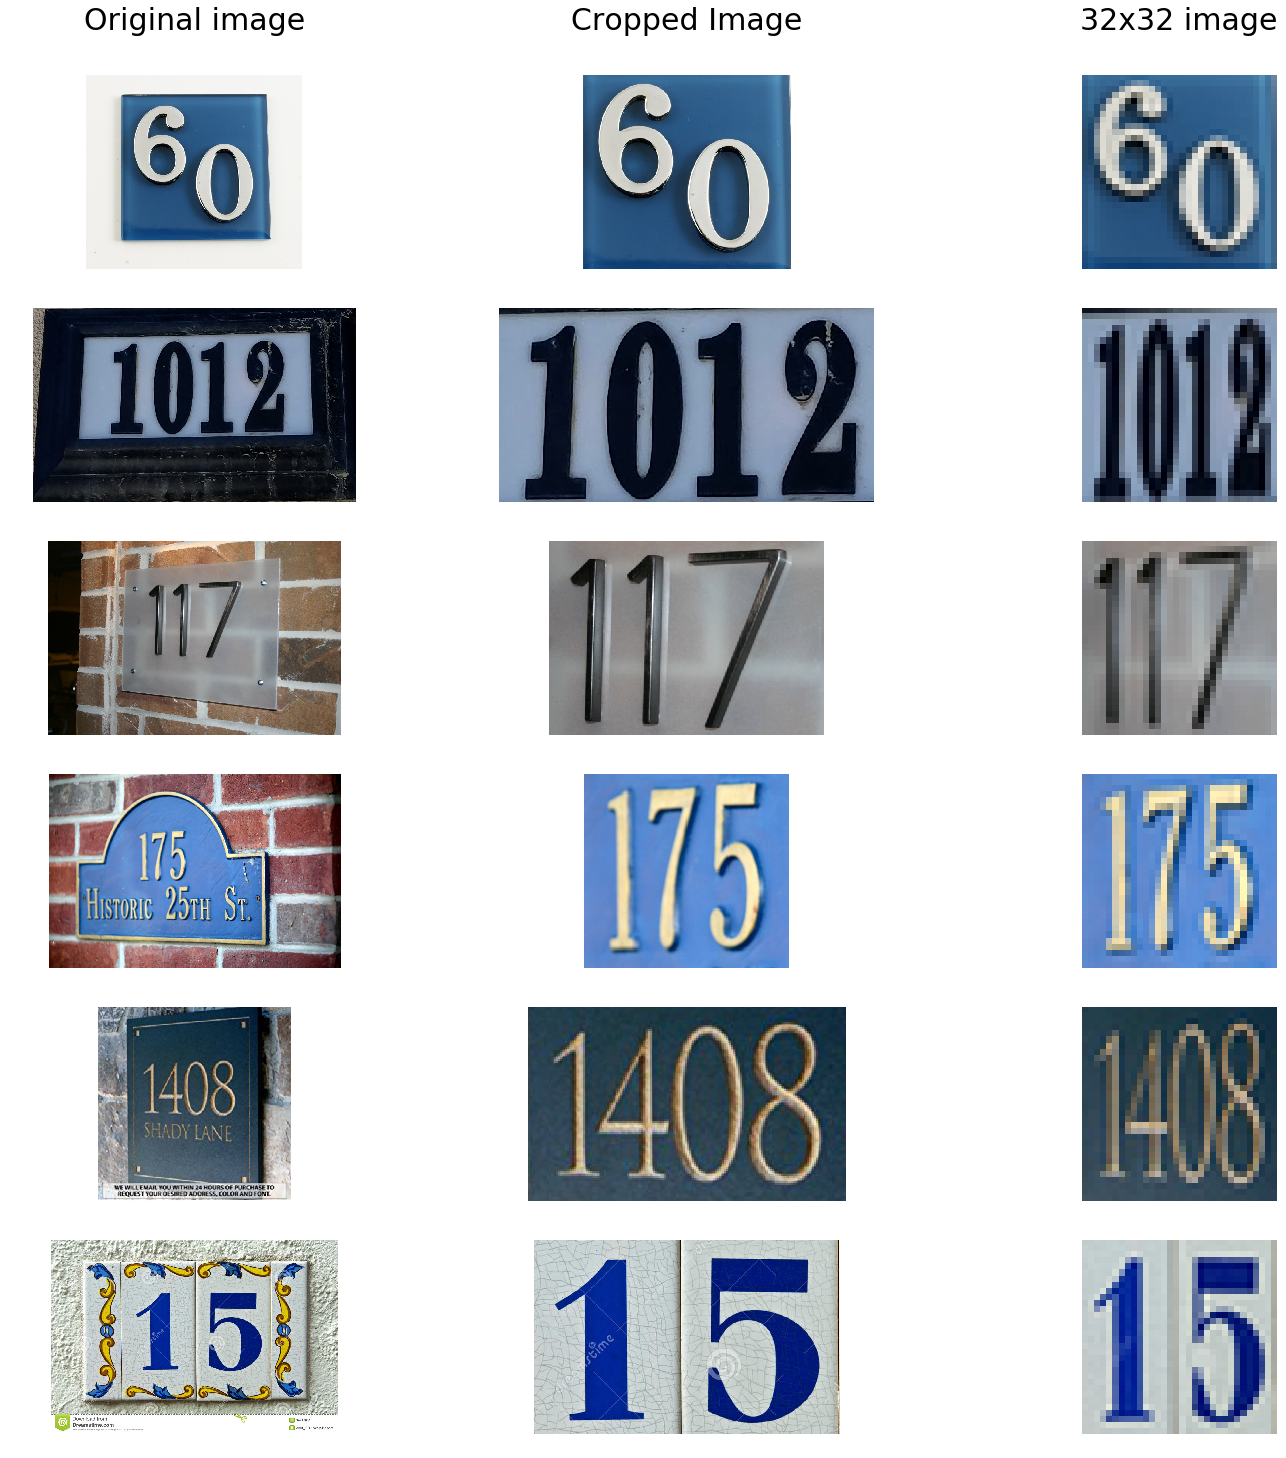

In [15]:
from PIL import Image
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (25, 25)
f, axes = plt.subplots(nrows=6, ncols=3)
for ax, col in zip(axes[0], ["Original image", "Cropped Image", "32x32 image"]):
    ax.set_title(col,fontsize=30,y=1.2)


#Since images are captured from random homes, they require different crops. Based upon the image shape and size, I figured
#following cropping for each of the images.
crop_matrix = {}
crop_matrix["home.jpg"] = (180, 75, 730, 360)
crop_matrix["home_1.jpg"] = (320, 130, 730, 420)
crop_matrix["home_2.jpg"] = (275, 180, 475, 370)
crop_matrix["home_3.jpg"] = (340, 200, 1000, 620)
crop_matrix["home_4.jpg"] = (120, 80, 590, 520)
crop_matrix["home_5.jpg"] = (60, 80, 240, 190)

#Defining an array to store random images such that it can be fed into Digit recognition model
random_images = np.ndarray([len(os.listdir("random_images")),32,32,1], dtype='float32')
images_32by32 = []


for i, item in enumerate(os.listdir("random_images")):    
    fullname = os.path.join('./random_images/', item)
    im = Image.open(fullname)
    axes[i,0].axis('off')
    axes[i,0].imshow(im)
    image = im.crop(crop_matrix[item])
    axes[i,1].axis('off')
    axes[i,1].imshow(image)
    image = image.resize([32, 32], Image.ANTIALIAS) # Resize image to 32x32
    images_32by32.append(image)
    axes[i,2].axis('off')
    axes[i,2].imshow(image)
    image = np.dot(np.array(image, dtype='float32'), [[0.2989],[0.5870],[0.1140]]) # Convert image to the grayscale
    mean = np.mean(image, dtype='float32')
    std = np.std(image, dtype='float32', ddof=1)
    if std < 0.0001: 
        std = 1.0
    image = (image - mean) / std
    random_images[i,:,:] = image[:,:,:]



In [19]:
with tf.Session(graph=graph) as session:
    #tf.global_variables_initializer().run()
    saver = tf.train.import_meta_graph('./svhn.convnet.meta')    
    saver.restore(session, './svhn.convnet')
    print("Model restored.")  
    
    print('Initialized')
    tf_test_dataset_home = tf.constant(random_images)
    test_logits_home = model(tf_test_dataset_home, 1.0, shape)
    test_prediction_home = tf.stack([tf.nn.softmax(test_logits_home[0]), tf.nn.softmax(test_logits_home[1]),\
                               tf.nn.softmax(test_logits_home[2]), tf.nn.softmax(test_logits_home[3]),\
                               tf.nn.softmax(test_logits_home[4])])
    final_test_prediction_home = tf.transpose(tf.argmax(test_prediction_home, 2))
    #test_prediction = session.run(test_prediction, feed_dict={tf_test_dataset : test_dataset[im_samples,:,:,:],})
    #predict,test_prediction = session.run([predict,test_prediction], feed_dict={tf_test_dataset : test_dataset[im_samples,:,:,:],})
    #print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:6]))
    #print ('Prediction is: ', final_test_prediction.eval()[11:21])
    final_test_prediction_home = final_test_prediction_home.eval()

Model restored.
Initialized
shape is:  [6, 1, 1, 512]
after reshape:  (6, 512)
hidden11 shape:  (6, 128)
hidden12 shape:  (6, 32)


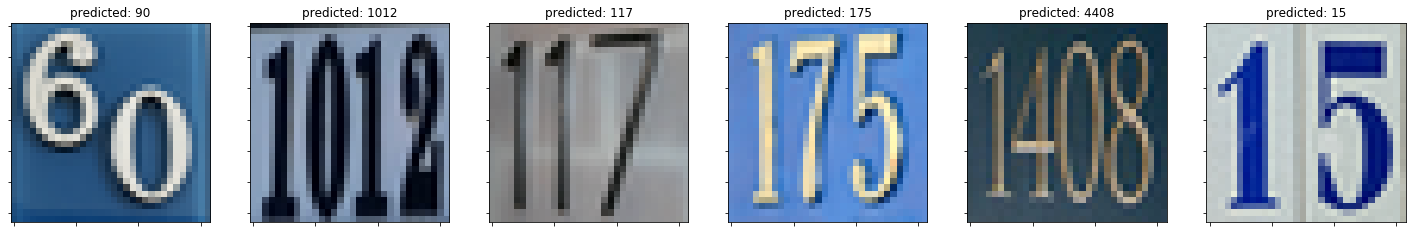

In [23]:
plt.rcParams['figure.figsize'] = (25.0, 25.0)
f, ax = plt.subplots(nrows=1, ncols=6)

for i, item in enumerate(images_32by32):
    #im = Image.open(item)    
    house_num_predicted = ''
    for k in np.arange(np.sum(final_test_prediction_home[i,:] != 10)):
        house_num_predicted += str(final_test_prediction_home[i,k])
    #ax[i].axis('off')
    ax[i].set_title("predicted: "+house_num_predicted, loc='center')
    ax[i].tick_params(labelbottom='off')
    ax[i].tick_params(labelleft='off')
    ax[i].imshow(item)

### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

**Answer:**

See above for 6 random images of the street number. Looks like result is not so accurate when numbers are not side by side.

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:**

Yes. As you can see above, the model performed equally well on images captured using my phone camera.

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** 

Newly acquired images were preprocessed same way as Training and Test images. I cropped the images to get rid of noise. Then, I resized, grayscaled and normalized the images.


----
### Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:**

Not sure what's the meaning of localize number is.

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

**Answer:**

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your optional code implementation goes here.
### Feel free to use as many code cells as needed.



### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.